### Pacotes:

In [1]:
import math
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.x13 import x13_arima_analysis, x13_arima_select_order
from statsmodels.tools.sm_exceptions import X13Error
from utils import build_absorbing_block_mask
from mscomp import MSComp

import seaborn as sns
sns.set_theme(style="darkgrid")

In [2]:
warnings.filterwarnings("ignore")

### PIB Brasil:

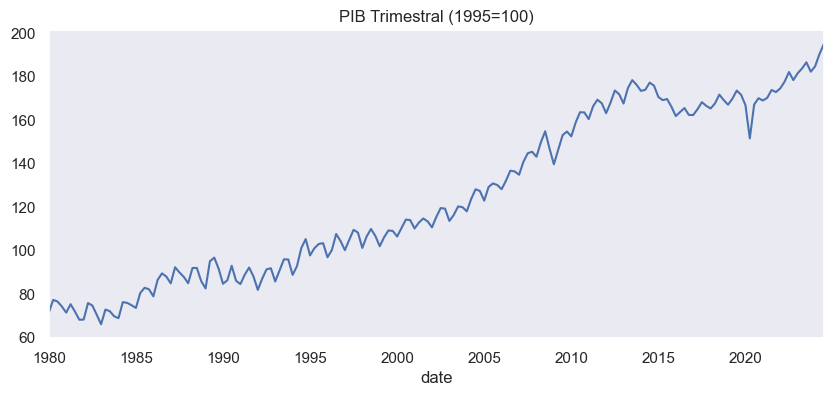

In [3]:
pib = pd.read_excel(r'C:\Users\jonas\OneDrive - MSFT\Desktop\PIB_total_1980_2025 - 2.xlsx')
pib.set_index('date', inplace=True)

pib.plot(y='pib', title='PIB Trimestral (1995=100)', legend=False, figsize=(10, 4))
plt.grid()
plt.show()

### Ajuste Sazonal:

In [4]:
try:
    result = x13_arima_analysis(pib['pib'], freq='Q', x12path='x13as')
    pib['pib_sa'] = result.seasadj
    print("Ajuste sazonal realizado com sucesso.")
    pib[['pib', 'pib_sa']].head()

except X13Error as e:
    print(f"Erro ao realizar o ajuste sazonal: {e}")

Ajuste sazonal realizado com sucesso.


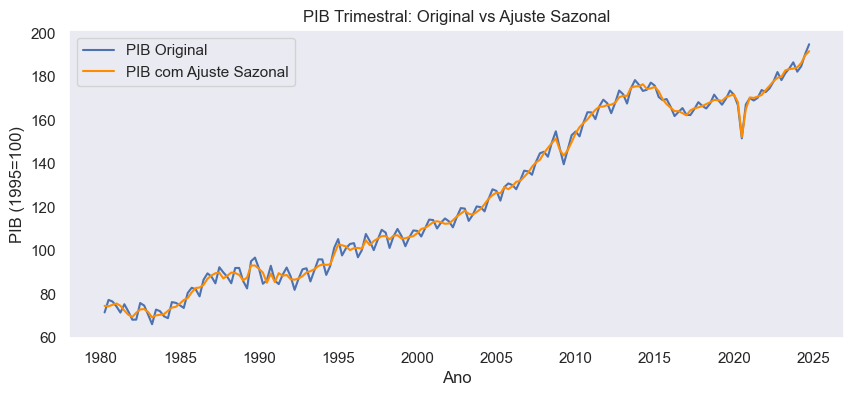

In [5]:
plt.figure(figsize=(10, 4))
plt.plot(pib.index, pib['pib'], label='PIB Original')
plt.plot(pib.index, pib['pib_sa'], label='PIB com Ajuste Sazonal', color='darkorange')
plt.title('PIB Trimestral: Original vs Ajuste Sazonal')
plt.xlabel('Ano')
plt.ylabel('PIB (1995=100)')
plt.legend()
plt.grid()
plt.show()

A série com ajuste sazonal vai ser transformada da seguinte forma

$$
y_t = 100 \ln \left( \frac{GDP_t}{GDP_{t-1}} \right)
$$

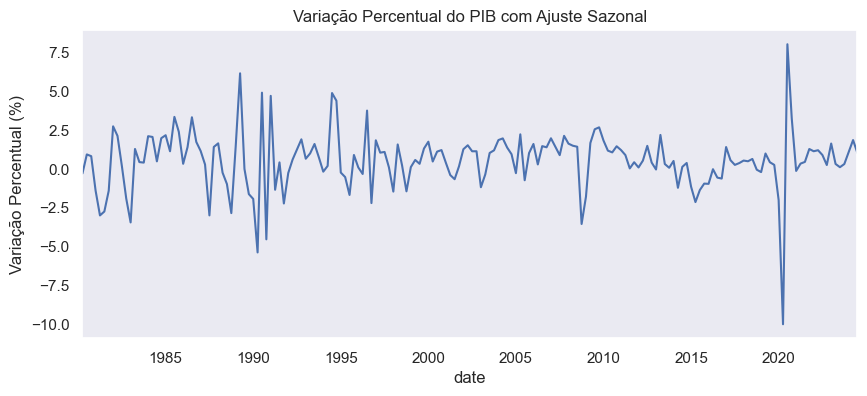

In [6]:
pib['y_t'] = 100 * np.log(pib['pib_sa'] / pib['pib_sa'].shift(1))
pib.dropna(inplace=True)

pib.plot(y='y_t', title='Variação Percentual do PIB com Ajuste Sazonal', legend=False, figsize=(10, 4))
plt.ylabel('Variação Percentual (%)')
plt.grid()
plt.show()

### MSComp-ARMA:

Especificação da quebra estrutural permanente em $P_m$:
$$
\mathbf{P}^m =
\begin{pmatrix}
p_{0|0} & p_{0|1} & 0 & 0 \\
p_{1|0} & p_{1|1} & 0 & 0 \\
0 & p_{2|1} & p_{2|2} & p_{2|3} \\
0 & 0 & p_{3|2} & p_{3|3}
\end{pmatrix}
.
$$

Modelo MSComp(4,2)-ARMA(2,2) é especificado como

$$
y_t = \mu(S_t^m) 
    + \phi_1(S_t^m)\big(y_{t-1} - \mu(S_{t-1}^m)\big)
    + \phi_2(S_t^m)\big(y_{t-2} - \mu(S_{t-2}^m)\big)
    + \epsilon_t
    + \theta_1(S_{t-1}^m)\epsilon_{t-1}
    + \theta_2(S_{t-2}^m)\epsilon_{t-2}
    \tag{3}
$$

onde $\epsilon_t \sim IIND[0, \sigma^2(S_t^v)]$, $S_t^m \in \{0,1,2,3\}$ and $S_t^v \in \{0,1\}$ e com a estrutura de Kronecker para a matriz de transição.

In [7]:
model = MSComp(
    # Modelo: MSComp(4,2)-ARMA(2,2):
    k_mean = 4,
    k_var = 2,
    ar_order = 2,
    ma_order = 2,

    # AR/MA por regime:
    share_ar_across_regimes = False,
    share_ma_across_regimes = False,

    # Rsar médias defasadas por regime (μ(S_{m,t-i})):
    exact_mu_lags = True,

    # Quebra estrutural:
    structural_break="absorbing_block",                               # None | 'absorbing_last' | 'absorbing_block'             
    absorbing_block_spec={"pre": 2, "post": 2, "bridge": (1, 2)},     # Use dict se estiver em 'absorbing_block'

    init_xi="auto",                                                   

    # Reprodutibilidade:
    random_state = 42
)

In [9]:
res = model.fit(
    pib["y_t"].to_numpy(dtype=float),
    X = None,
    maxiter = 1,
    tol = 1e-6,
    method = "L-BFGS-B",
    verbose = True,
    n_starts = 1,
    random_state = 42
)

In [10]:
p_mean  = np.asarray(res.mean_regime_probs)
p_var   = np.asarray(res.var_regime_probs)

T = p_mean.shape[0]
idx = pib.index[-T:]  # alinha índice temporal ao tamanho das probabilidades

p_mean_df = pd.DataFrame(p_mean, index=idx, columns=[f"mean_regime_{i}" for i in range(p_mean.shape[1])])
p_var_df  = pd.DataFrame(p_var,  index=idx, columns=[f"var_regime_{i}"  for i in range(p_var.shape[1])])

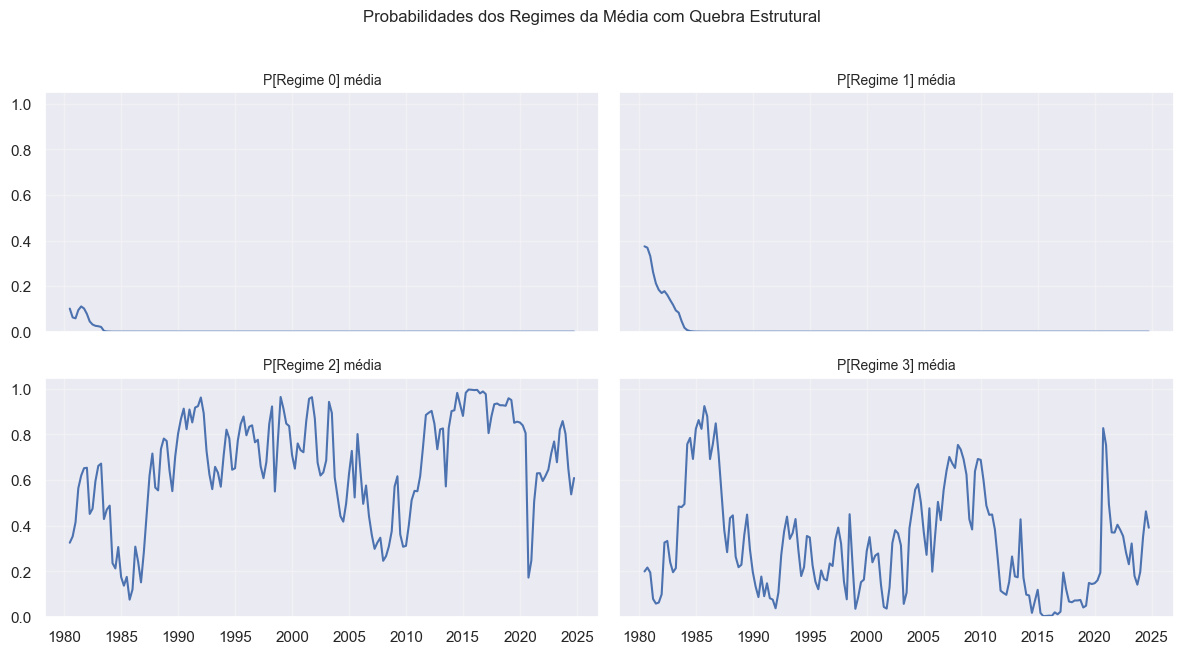

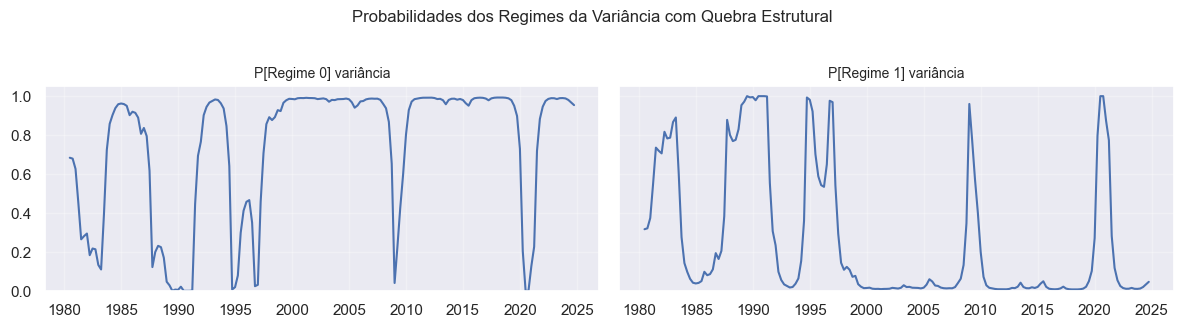

In [11]:
def plot_regimes_em_grade(P, x=None, titulo_figura="", sufixo_titulo="",
                        ncols=2, sharex=True, sharey=True):
    """
    P: array (T, K) com probabilidades por regime
    x: eixo do tempo (opcional). Se None, usa np.arange(T)
    """
    P = np.asarray(P)
    T, K = P.shape
    if x is None:
        x = np.arange(T)

    nrows = math.ceil(K / ncols)

    fig, axs = plt.subplots(nrows, ncols, figsize=(12, 3.2 * nrows),
                            sharex=sharex, sharey=sharey)
    axs = np.atleast_1d(axs).ravel()

    for i in range(K):
        ax = axs[i]
        ax.plot(x, P[:, i])  # usa cores padrão do matplotlib
        ax.set_title(f"P[Regime {i}] {sufixo_titulo}".strip(), fontsize=10)
        ax.set_ylim(0, 1.05)
        ax.grid(True, alpha=0.3)

    # Desliga eixos sobrando se K não fechar a grade
    for j in range(K, len(axs)):
        axs[j].axis("off")

    fig.suptitle(titulo_figura, y=1.02, fontsize=12)
    fig.tight_layout()
    plt.show()

plot_regimes_em_grade(
    p_mean,
    x=pib.index,
    titulo_figura="Probabilidades dos Regimes da Média com Quebra Estrutural",
    sufixo_titulo="média",
    ncols=2
)

plot_regimes_em_grade(
    p_var,
    x=pib.index,
    titulo_figura="Probabilidades dos Regimes da Variância com Quebra Estrutural",
    sufixo_titulo="variância",
    ncols=2
)

-------

In [7]:
model = MSComp(
    k_mean=4,
    k_var=2,

    ar_order=2,
    ma_order=2,

    share_ar_across_regimes=False,
    share_ma_across_regimes=False,

    ma_regime_timing="lagged",

    structural_break="absorbing_block",
    absorbing_block_spec={"pre": 2, "post": 2, "bridge": (1, 2)},

    mask_convention="paper_pij",  # apenas para I/O (o interno continua "from_to")
)

In [9]:
res = model.fit(
    y=pib["y_t"].to_numpy(dtype=float),
    method="L-BFGS-B",
    n_starts=1,
    maxiter=1,
    tol=1e-6,
    verbose=True,
    random_state=123
)

In [18]:
print(model.summary())

=== MSComp Results ===
log-likelihood: -332.275
Mean regimes: 4, Variance regimes: 2, AR order: 2, MA order: 2
Intercepts (a_i): -1.4716, -0.3041, 0.0207, 1.4404
AR coefficients by regime (flattened): 0.0313, 0.0053, 0.0826, -0.0507, 0.1223, 0.1426, 0.0572, 0.0039
MA coefficients by regime (flattened): 0.0300, -0.0093, 0.0790, -0.0519, 0.1197, 0.1426, 0.1426, 0.0694
Sigma^2 (variance regimes): 1.022955, 9.320193
Pm (mean transitions):
[[ 0.8489  0.1511  0.0000  0.0000]
 [ 0.0343  0.8488  0.1169  0.0000]
 [ 0.0000  0.0000  0.9112  0.0888]
 [ 0.0000  0.0000  0.2422  0.7578]]
Pv (variance transitions):
[[ 0.9244  0.0756]
 [ 0.1387  0.8613]]
Min |root_AR| por regime: 11.116261298, 4.439663648, 2.253648961, 10.253019689
Gap_AR (min|root|-1): 10.116261298, 3.439663648, 1.253648961, 9.253019689
Gap_AR_to_target (min|root|-target): 10.086261298, 3.409663648, 1.223648961, 9.223019689
Min |root_MA| por regime: 8.871553825, 3.694770571, 2.647856586, 3.796357708
Gap_MA (min|root|-1): 7.871553825, 

In [11]:
print("k_mean, k_var:", res.k_mean, res.k_var)
print("use_expanded_mean:", res.use_expanded_mean, "k_mean_chain:", res.k_mean_chain)

k_mean, k_var: 4 2
use_expanded_mean: True k_mean_chain: 64


In [13]:
T = len(pib["y_t"])
km = res.k_mean
kv = res.k_var

filtered_joint = res.filtered_probs      # (T, k_joint)
smoothed_joint = res.smoothed_probs      # (T, k_joint)

In [14]:
def mean_marginal_from_joint(joint_probs, res):
    """
    Retorna (T, k_mean) marginalizando a variância e, se necessário,
    colapsando a cadeia expandida da média para o regime corrente S_t.
    """
    kv = res.k_var
    if not res.use_expanded_mean:
        km = res.k_mean
        return joint_probs.reshape(-1, km, kv).sum(axis=2)

    # caso expandido: joint é (T, k_mean_chain * k_var)
    km = res.k_mean
    kmc = res.k_mean_chain
    L = max(res.ar_order, res.ma_order) + 1

    # primeiro marginaliza variância => (T, kmc)
    chain_probs = joint_probs.reshape(-1, kmc, kv).sum(axis=2)

    # decoder do mesmo jeito que o código: product(range(km), repeat=L)
    # e o regime corrente é st[0]
    from itertools import product
    decoder = list(product(range(km), repeat=L))
    assert len(decoder) == kmc

    out = np.zeros((chain_probs.shape[0], km))
    for idx, st in enumerate(decoder):
        out[:, st[0]] += chain_probs[:, idx]
    return out

def var_marginal_from_joint(joint_probs, res):
    """
    Retorna (T, k_var) marginalizando a média (cadeia ou não).
    """
    kv = res.k_var
    if not res.use_expanded_mean:
        km = res.k_mean
        return joint_probs.reshape(-1, km, kv).sum(axis=1)

    kmc = res.k_mean_chain
    return joint_probs.reshape(-1, kmc, kv).sum(axis=1)

In [15]:
filtered_mean = mean_marginal_from_joint(filtered_joint, res)
smoothed_mean = mean_marginal_from_joint(smoothed_joint, res)

filtered_var = var_marginal_from_joint(filtered_joint, res)
smoothed_var = var_marginal_from_joint(smoothed_joint, res)

In [16]:
if res.mean_regime_probs is not None:
    print("max|smoothed_mean - res.mean_regime_probs| =",
            np.max(np.abs(smoothed_mean - res.mean_regime_probs)))

if res.var_regime_probs is not None:
    print("max|smoothed_var - res.var_regime_probs| =",
            np.max(np.abs(smoothed_var - res.var_regime_probs)))

max|smoothed_mean - res.mean_regime_probs| = 0.9954843751757076
max|smoothed_var - res.var_regime_probs| = 0.9025053426042638


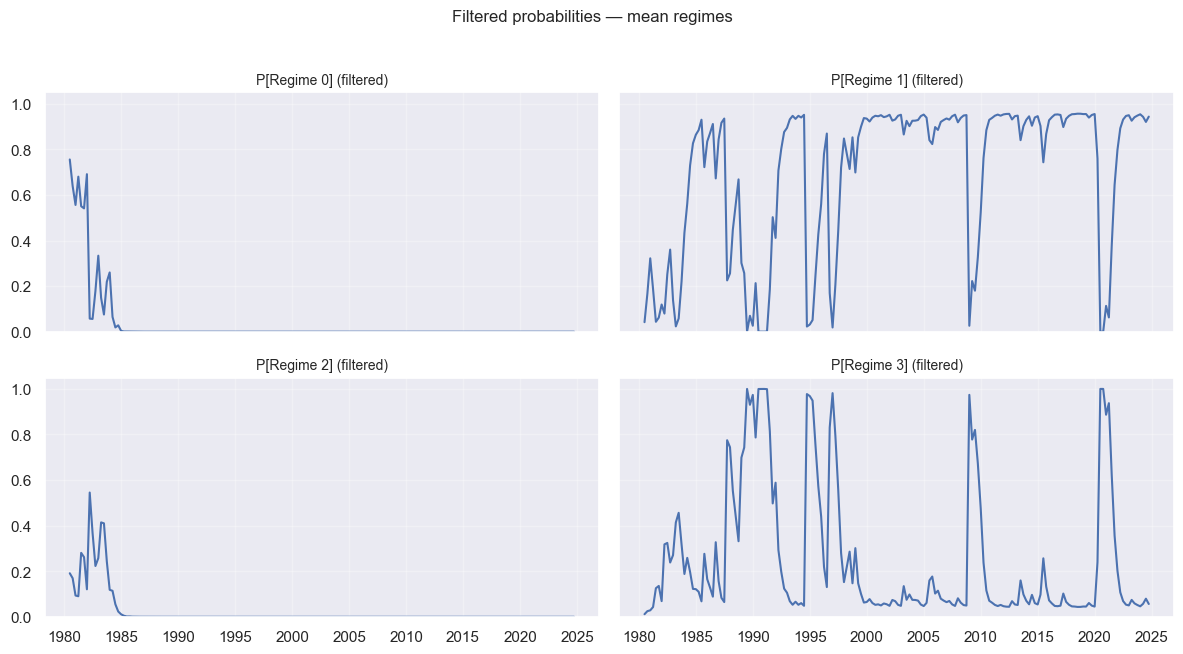

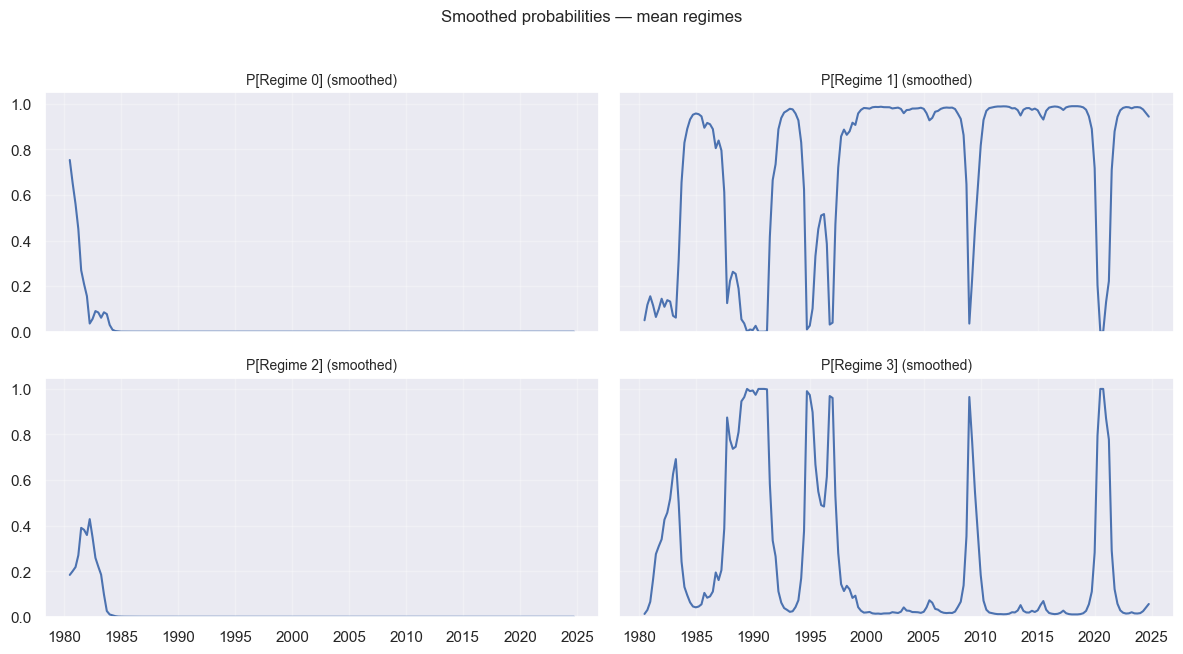

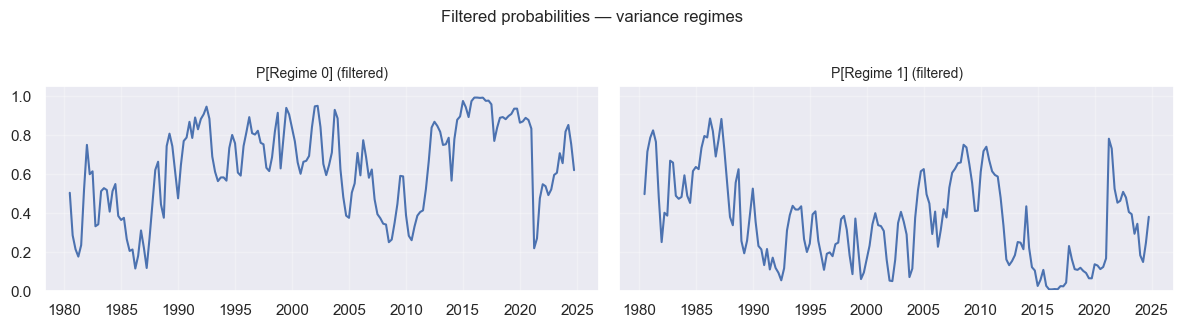

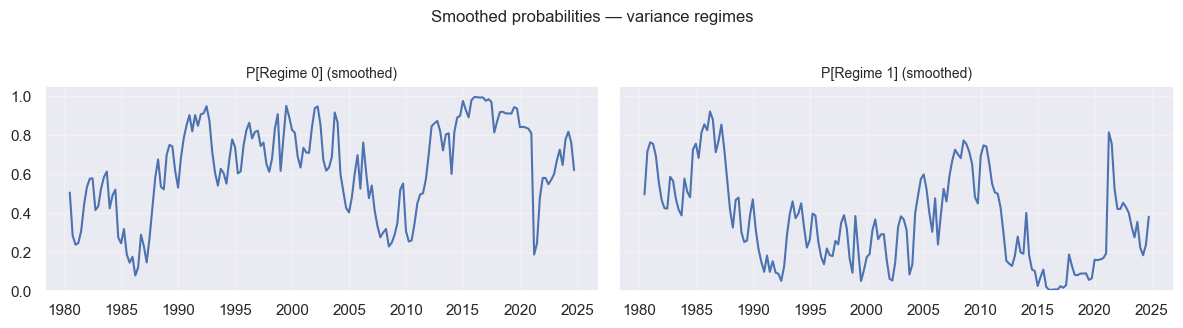

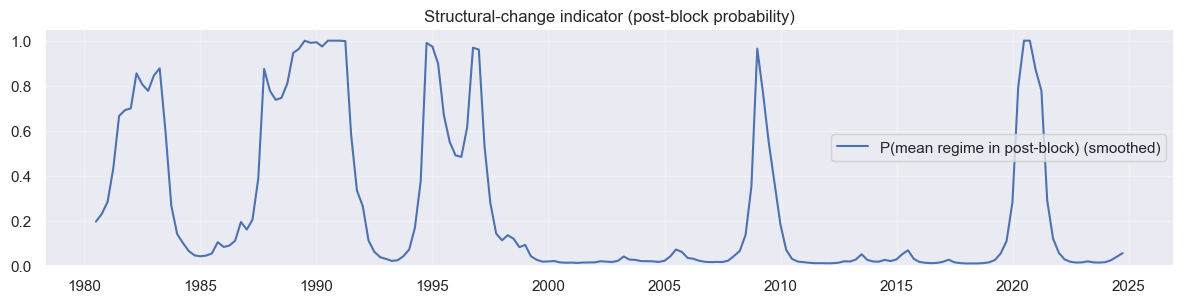

In [ ]:
def plot(P, x=None, titulo_figura="", sufixo_titulo="",
                            ncols=2, sharex=True, sharey=True):
    """
    P: array (T, K) com probabilidades por regime
    x: eixo do tempo (opcional). Se None, usa np.arange(T)
    """
    P = np.asarray(P)
    if P.ndim != 2:
        raise ValueError(f"P deve ser 2D (T,K). Recebido shape={P.shape}")
    T, K = P.shape

    if x is None:
        x = np.arange(T)
    else:
        x = np.asarray(x)
        if x.shape[0] != T:
            raise ValueError(f"x deve ter comprimento T={T}. Recebido len(x)={x.shape[0]}")

    ncols = max(1, min(int(ncols), K))
    nrows = math.ceil(K / ncols)

    fig, axs = plt.subplots(nrows, ncols, figsize=(12, 3.2 * nrows),
                            sharex=sharex, sharey=sharey)
    axs = np.atleast_1d(axs).ravel()

    for i in range(K):
        ax = axs[i]
        ax.plot(x, P[:, i])  # cores padrão do matplotlib
        ax.set_title(f"P[Regime {i}] {sufixo_titulo}".strip(), fontsize=10)
        ax.set_ylim(0, 1.05)
        ax.grid(True, alpha=0.3)

    for j in range(K, len(axs)):
        axs[j].axis("off")

    if titulo_figura:
        fig.suptitle(titulo_figura, y=1.02, fontsize=12)

    fig.tight_layout()
    return fig, axs

dates = pib.index.to_numpy()

# (a) Probabilidades por regime de média (filtradas)
plot(
    filtered_mean,
    x=dates,
    titulo_figura="Filtered probabilities — mean regimes",
    sufixo_titulo="(filtered)",
    ncols=2
)

# (b) Probabilidades por regime de média (suavizadas)
plot(
    smoothed_mean,
    x=dates,
    titulo_figura="Smoothed probabilities — mean regimes",
    sufixo_titulo="(smoothed)",
    ncols=2
)

# (c) Probabilidades por regime de variância (filtradas)
plot(
    filtered_var,
    x=dates,
    titulo_figura="Filtered probabilities — variance regimes",
    sufixo_titulo="(filtered)",
    ncols=2
)

# (d) Probabilidades por regime de variância (suavizadas)
plot(
    smoothed_var,
    x=dates,
    titulo_figura="Smoothed probabilities — variance regimes",
    sufixo_titulo="(smoothed)",
    ncols=2
)

# (e) Indicador “pós-quebra” (bloco pós = regimes 2 e 3, dado pre=2, post=2)
post_prob = np.asarray(smoothed_mean)[:, 2:].sum(axis=1)

fig, ax = plt.subplots(figsize=(12, 3.2))
ax.plot(dates, post_prob, label="P(mean regime in post-block) (smoothed)")
ax.set_title("Structural-change indicator (post-block probability)")
ax.set_ylim(0, 1.05)
ax.grid(True, alpha=0.3)
ax.legend()
fig.tight_layout()

plt.show()

In [24]:
print("Pm (from_to) row-stochastic? row sums:", res.Pm.sum(axis=1))
print()
print("Pm_pij (paper convention) col-stochastic? col sums:", res.Pm_pij.sum(axis=0))
print()
print("Pm_pij:\n", res.Pm_pij)
print()
print("Pv_pij:\n", res.Pv_pij)

Pm (from_to) row-stochastic? row sums: [1. 1. 1. 1.]

Pm_pij (paper convention) col-stochastic? col sums: [1. 1. 1. 1.]

Pm_pij:
 [[0.84891213 0.0342887  0.         0.        ]
 [0.15108787 0.84879196 0.         0.        ]
 [0.         0.11691934 0.91117444 0.24221137]
 [0.         0.         0.08882556 0.75778863]]

Pv_pij:
 [[0.92444002 0.13873283]
 [0.07555998 0.86126717]]


------

In [26]:
def plot_regimes_em_grade(P, x=None, titulo_figura="", sufixo_titulo="",
                        ncols=2, sharex=True, sharey=True):
    """
    P: array (T, K) com probabilidades por regime
    x: eixo do tempo (opcional). Se None, usa np.arange(T)
    """
    P = np.asarray(P)
    T, K = P.shape
    if x is None:
        x = np.arange(T)

    nrows = math.ceil(K / ncols)

    fig, axs = plt.subplots(nrows, ncols, figsize=(12, 3.2 * nrows),
                            sharex=sharex, sharey=sharey)
    axs = np.atleast_1d(axs).ravel()

    for i in range(K):
        ax = axs[i]
        ax.plot(x, P[:, i])  # usa cores padrão do matplotlib
        ax.set_title(f"P[Regime {i}] {sufixo_titulo}".strip(), fontsize=10)
        ax.set_ylim(0, 1.05)
        ax.grid(True, alpha=0.3)

    # Desliga eixos sobrando se K não fechar a grade
    for j in range(K, len(axs)):
        axs[j].axis("off")

    fig.suptitle(titulo_figura, y=1.02, fontsize=12)
    fig.tight_layout()
    plt.show()

In [29]:
p_mean  = np.asarray(res.mean_regime_probs)
p_var   = np.asarray(res.var_regime_probs)

T = p_mean.shape[0]
idx = pib.index[-T:]  # alinha índice temporal ao tamanho das probabilidades

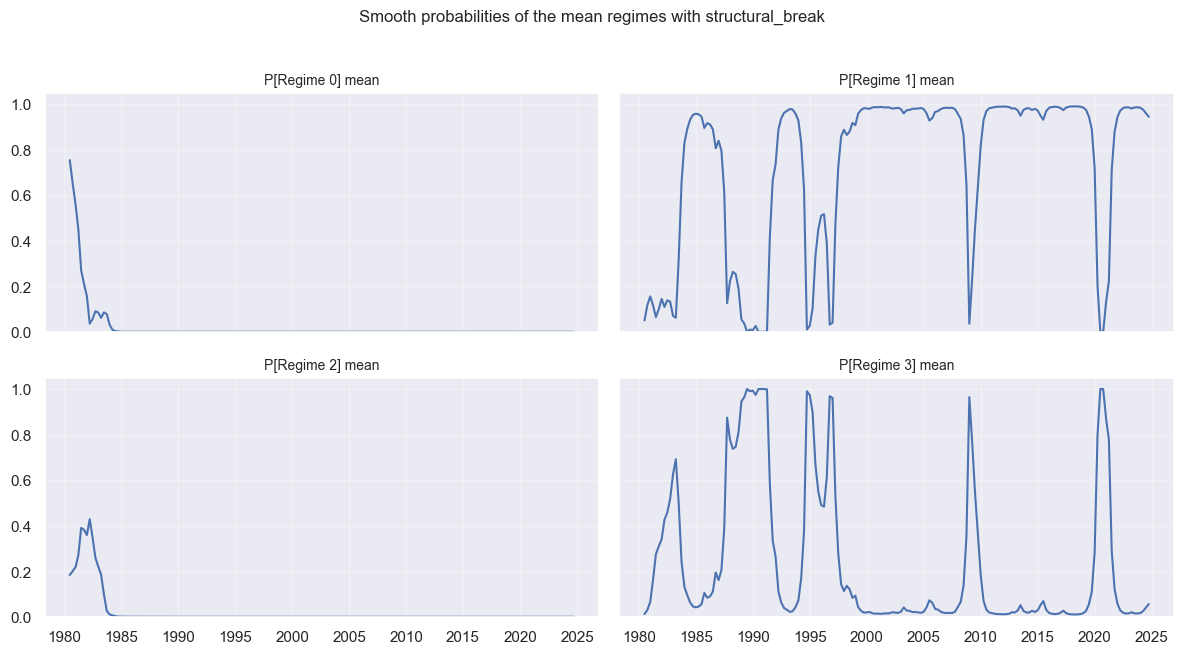

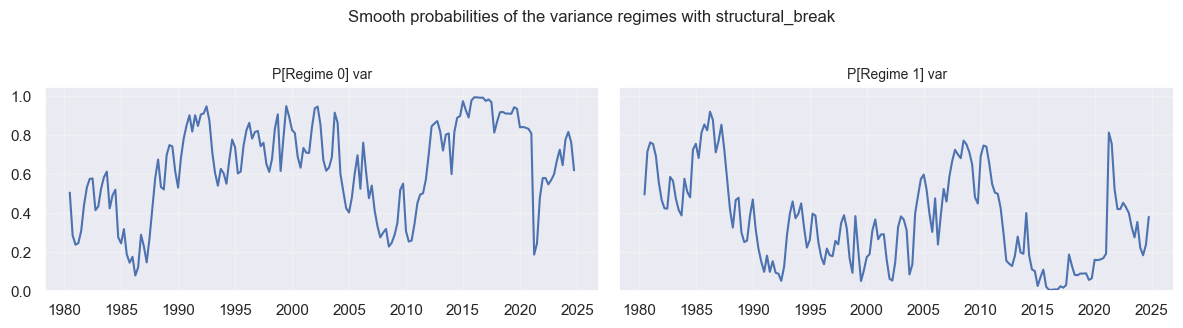

In [48]:
plot_regimes_em_grade(
    smoothed_mean,
    x=dates,
    titulo_figura="Smooth probabilities of the mean regimes with structural_break",
    sufixo_titulo="mean",
    ncols=2
)

plot_regimes_em_grade(
    smoothed_var,
    x=dates,
    titulo_figura="Smooth probabilities of the variance regimes with structural_break",
    sufixo_titulo="var",
    ncols=2
)

### Doornik (2013)

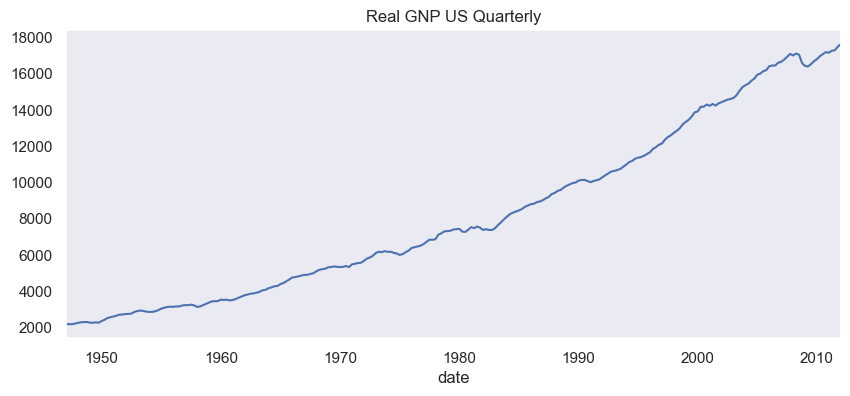

In [37]:
gnp = pd.read_excel(r'C:\Users\jonas\OneDrive - MSFT\Desktop\PPA Crédito\Modelos Markov\dados\Real_GNP_US.xlsx')
gnp.set_index('date', inplace=True)

gnp.plot(y='real_gnp', title='Real GNP US Quarterly', legend=False, figsize=(10, 4))
plt.grid()
plt.show()

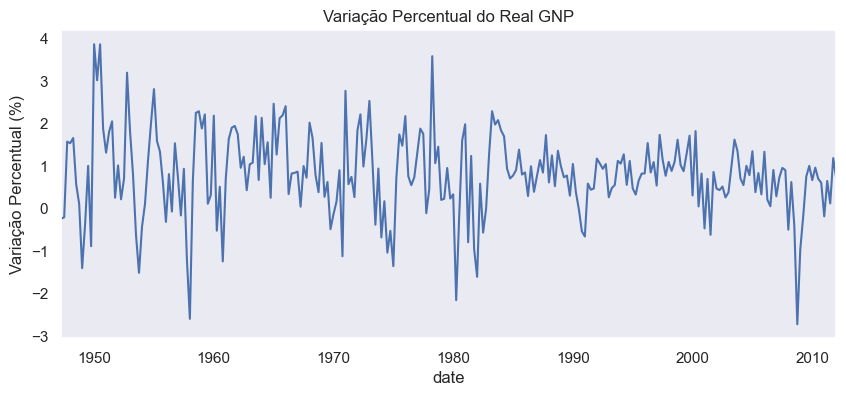

In [38]:
gnp['y_t'] = 100 * np.log(gnp['real_gnp'] / gnp['real_gnp'].shift(1))
gnp.dropna(inplace=True)

gnp.plot(y='y_t', title='Variação Percentual do Real GNP', legend=False, figsize=(10, 4))
plt.ylabel('Variação Percentual (%)')
plt.grid()
plt.show()

In [39]:
model = MSComp(
    k_mean=3,           # número de regimes na média
    k_var=2,            # número de regimes na variância
    ar_order=0,         # sem defasagens AR (ou use ar_order=p se tiver)
    ma_order=0,         # sem MA (ou use ma_order=q se tiver)
    
    # Regressão dinâmica / variáveis exógenas
    D=2,                                    # 2 variáveis exógenas (DR(2))
    exog_lags=0,                            # quantas defasagens das exógenas usar (0 = sem lag)
    share_beta_across_regimes=False,        # coeficientes variam por regime (recomendado)
    
    # Reprodutibilidade
    random_state=42
)

In [40]:
X = np.zeros((len(gnp), 2), dtype=float)

# Variável exógena 1: y defasado em 1 período
X[1:, 0] = gnp['y_t'].values[:-1]
X[0, 0] = np.nan  # primeira linha indefinida

# Variável exógena 2: y defasado em 2 períodos
X[2:, 1] = gnp['y_t'].values[:-2]
X[:2, 1] = np.nan  # primeiras duas linhas indefinidas

# Remover linhas com NaN
valid_idx = ~np.isnan(X).any(axis=1)
y_clean = gnp['y_t'].values[valid_idx]
X_clean = X[valid_idx]

print(f"Shape de X: {X_clean.shape}")
print(f"Shape de y: {y_clean.shape}")
print("Primeiras linhas de X:")
print(X_clean[:5])

Shape de X: (258, 2)
Shape de y: (258,)
Primeiras linhas de X:
[[-0.20682219 -0.2386289 ]
 [ 1.57563728 -0.20682219]
 [ 1.53843176  1.57563728]
 [ 1.66051908  1.53843176]
 [ 0.57276482  1.66051908]]


In [41]:
X_clean_normalized = (X_clean - X_clean.mean(axis=0)) / X_clean.std(axis=0)

In [42]:
res = model.fit(
    y_clean,                  # série temporal (1D array)
    X=X_clean,                # matriz de regressores (T, 2)
    maxiter=10,
    tol=1e-6,
    method="L-BFGS-B",
    n_starts=2
)

print(model.summary())

=== MSComp Results ===
log-likelihood: -315.696
Mean regimes: 3, Variance regimes: 2, AR order: 0, MA order: 0
Intercepts (a_i): 0.2436, 0.4107, 1.0866
DR (beta), q=2, Lx=0: 0.0658, 0.5771, 0.4097, 0.0255, -0.1121, 0.0504
Sigma^2 (variance regimes): 0.200931, 1.394872
Pm (mean transitions):
[[ 0.7935  0.1080  0.0985]
 [ 0.0574  0.8942  0.0484]
 [ 0.1159  0.1446  0.7395]]
Pv (variance transitions):
[[ 0.9350  0.0650]
 [ 0.0842  0.9158]]
Root margin target: 0.030000
Root target effective: 1.030000
Rescue frac (filtro): 0.0000
Mask respected (Pm[~mask]=0): True
Mask respected (effective): True
P == kron(Pv,Pm)? True


In [43]:
p_mean  = res.mean_regime_probs
p_var   = res.var_regime_probs

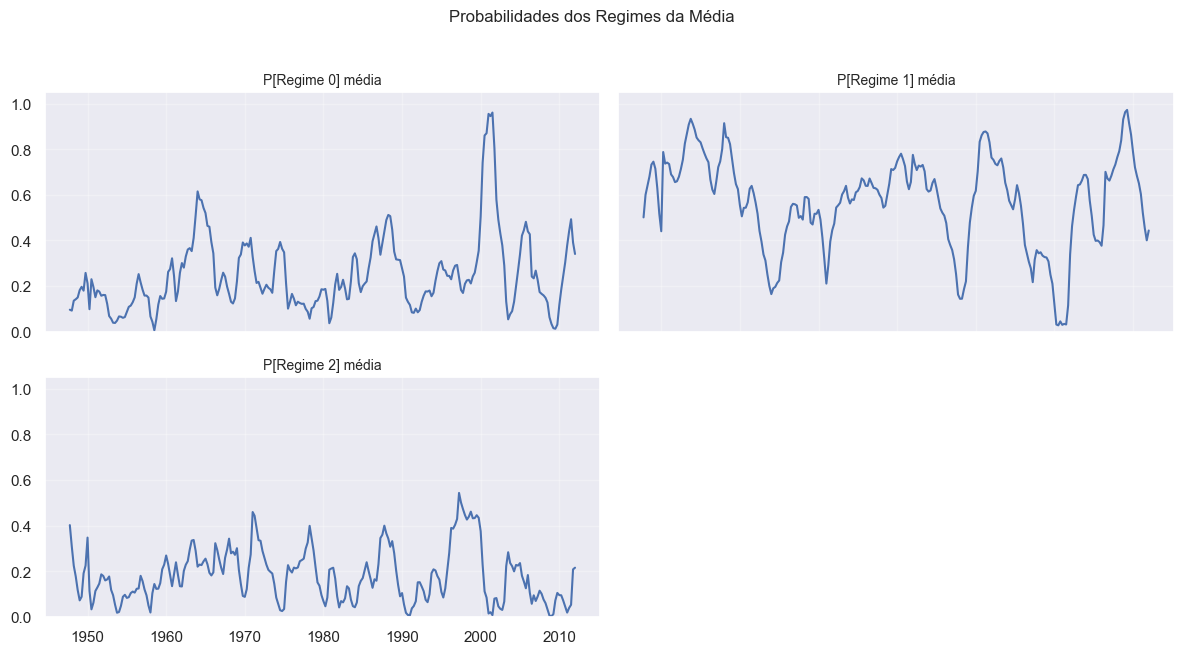

In [44]:
def plot_regimes_em_grade(P, x=None, titulo_figura="", sufixo_titulo="",
                        ncols=2, sharex=True, sharey=True):
    """
    P: array (T, K) com probabilidades por regime
    x: eixo do tempo (opcional). Se None, usa np.arange(T)
    """
    P = np.asarray(P)
    T, K = P.shape
    if x is None:
        x = np.arange(T)

    nrows = math.ceil(K / ncols)

    fig, axs = plt.subplots(nrows, ncols, figsize=(12, 3.2 * nrows),
                            sharex=sharex, sharey=sharey)
    axs = np.atleast_1d(axs).ravel()

    for i in range(K):
        ax = axs[i]
        ax.plot(x, P[:, i])  # usa cores padrão do matplotlib
        ax.set_title(f"P[Regime {i}] {sufixo_titulo}".strip(), fontsize=10)
        ax.set_ylim(0, 1.05)
        ax.grid(True, alpha=0.3)

    # Desliga eixos sobrando se K não fechar a grade
    for j in range(K, len(axs)):
        axs[j].axis("off")

    fig.suptitle(titulo_figura, y=1.02, fontsize=12)
    fig.tight_layout()
    plt.show()

plot_regimes_em_grade(
    p_mean,
    x=gnp.index[valid_idx],  # alinhar eixo de tempo com a seleção usada para y_clean/X_clean
    titulo_figura="Probabilidades dos Regimes da Média",
    sufixo_titulo="média",
    ncols=2
)

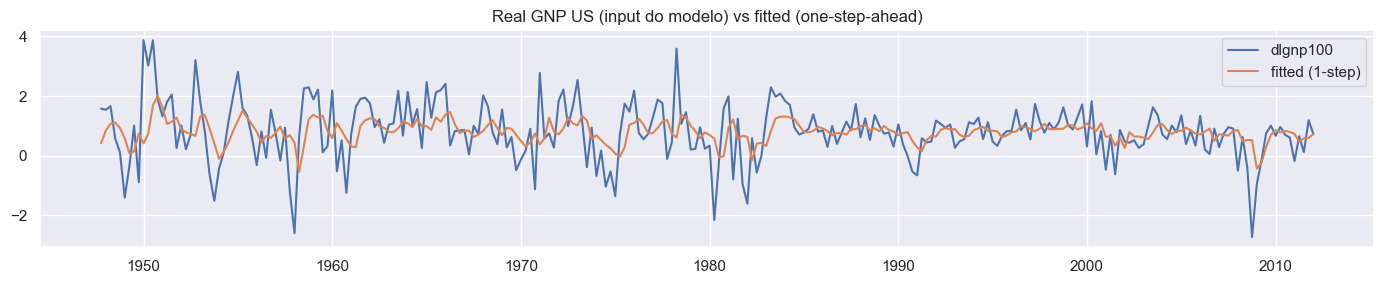

In [45]:
filtered = np.asarray(res.filtered_probs, float)
smooth   = np.asarray(res.smoothed_probs, float)
P        = np.asarray(res.P, float)

yhat = np.asarray(res.fitted, float).ravel()
Tobs = filtered.shape[0]

# alinhamento (res.fitted tem o mesmo Tobs da série usada)
assert yhat.shape[0] == Tobs

# 1) y vs fitted
plt.figure(figsize=(14,3))

# usar apenas os índices válidos (mesma seleção usada para y_clean / X_clean)
time_idx = gnp["y_t"].index[valid_idx]

plt.plot(time_idx, gnp["y_t"].to_numpy(dtype=float)[valid_idx], label="dlgnp100")
plt.plot(time_idx, yhat, label="fitted (1-step)")
plt.legend()
plt.title("Real GNP US (input do modelo) vs fitted (one-step-ahead)")
plt.tight_layout()
# plt.savefig(os.path.join(OUT_DIR, "y_vs_fitted.png"), dpi=150)
plt.show()